# TP3

Elaborado por: Alan Churichi

In [43]:
%load_ext lab_black

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
   
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2.
   
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

Cargamos las imagenes a procesar.

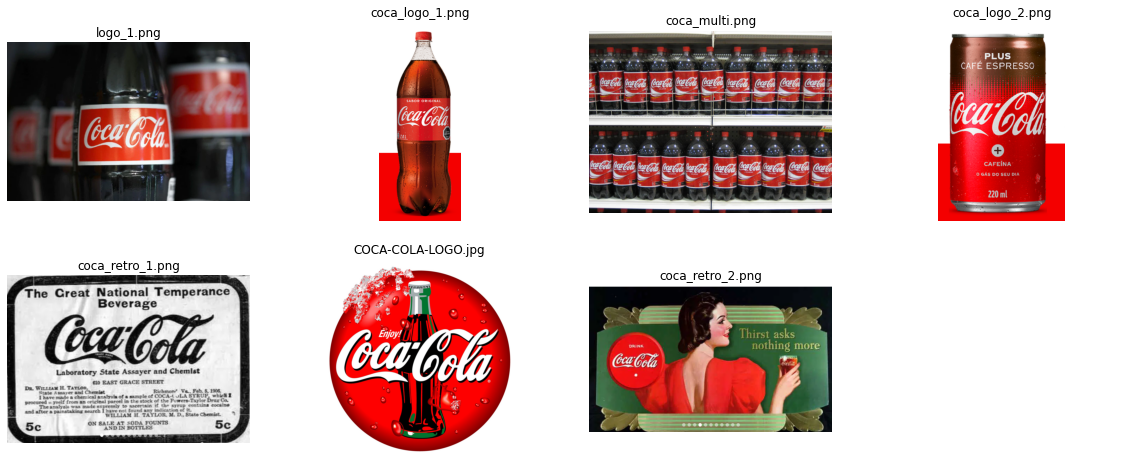

In [44]:
def load_image(path, filename, grayscale=False):
    flags = {"flags": cv.IMREAD_GRAYSCALE} if grayscale else {}
    img = cv.imread(os.path.join(path, filename), **flags)
    if grayscale:
        return img
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)


base_path = "/tf/notebooks/CEIA/computer-vision-1/tp3/assets"
images_path = os.path.join(base_path, "images")

filenames = os.listdir(images_path)
images = [load_image(images_path, filename) for filename in filenames]

_, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(2):
    for j in range(4):
        idx = i * 4 + j
        if idx < 7:
            axes[i][j].imshow(images[idx])
            axes[i][j].title.set_text(filenames[idx])
        axes[i][j].axis("off")

Cargamos el template que utilizaremos.

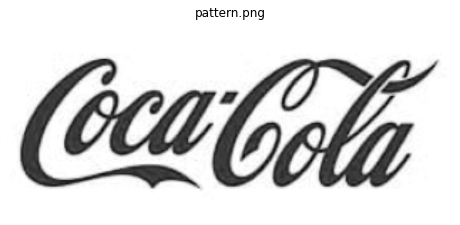

In [45]:
template_path = os.path.join(base_path, "template")

template = load_image(template_path, "pattern.png", grayscale=True)

plt.figure(figsize=(8, 8))
plt.imshow(template, cmap="gray")
plt.axis("off")
plt.title("pattern.png")
plt.show()

A continuación cargamos la imagen 'fft_alfa_pred.png' en escala de grises y le aplicamos filtros gausianos generados distintos tamaños de kernel y desviación estándar.

In [46]:
def generate_pyramid(img, min_scale=0.1, max_scale=10, steps=10):
    pyramid = []

    if min_scale <= 0 or max_scale <= 0 or min_scale >= max_scale:
        raise Exception("Invalid values")
    if max_scale > 1 and min_scale < 1:
        scale_down = np.linspace(min_scale, 1, steps, endpoint=False)
        scale_up = np.linspace(1, max_scale, steps)
        scales = np.concatenate((scale_down, scale_up))
    else:
        scales = np.linspace(min_scale, max_scale, steps)
    scales
    (h, w) = img.shape

    for scale in scales:
        if scale == 1:
            pyramid.append(img)
        else:
            pyramid.append(
                cv.resize(
                    img,
                    (round(w * scale), round(h * scale)),
                    interpolation=cv.INTER_AREA if scale < 1 else cv.INTER_CUBIC,
                )
            )

    return pyramid

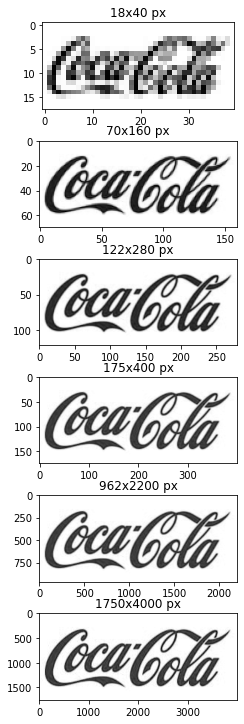

In [47]:
pyramid = generate_pyramid(template, 0.1, 10, 3)

_, axes = plt.subplots(len(pyramid), figsize=(10, 10))
plt.tight_layout()
for i in range(len(pyramid)):
    img = pyramid[i]
    axes[i].imshow(img, cmap="gray")
    axes[i].title.set_text(f"{img.shape[0]}x{img.shape[1]} px")

In [48]:
GREEN_COLOR = (0, 255, 0)


def match_template(
    img,
    template,
    min_scale=0.1,
    max_scale=10,
    steps=10,
    threshold=None,
    method=cv.TM_CCOEFF_NORMED,
):
    template_inv = cv.bitwise_not(template)
    template_pyramid = [
        *generate_pyramid(template, min_scale, max_scale, steps),
        *generate_pyramid(template_inv, min_scale, max_scale, steps),
    ]

    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    results = []
    for template_scaled in template_pyramid:
        try:
            res = cv.matchTemplate(img_gray, template_scaled, method)
            h, w = template_scaled.shape

            if threshold:
                loc = np.where(res >= threshold)
                relevant_detections = []
                for pt in zip(*loc[::-1]):
                    x, y = pt
                    relevant_detections.append((res[y, x], x, y, w, h))
                results.append(relevant_detections)
            else:
                _, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                x, y = (
                    min_loc
                    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
                    else max_loc
                )
                results.append([(max_val, x, y, w, h)])
        except:
            results.append([(0, 0, 0, 0, 0)])

    return max(results, key=lambda res: sum(item[0] for item in res))


def match_template_plot(
    img,
    template,
    min_scale=0.1,
    max_scale=10,
    steps=10,
    threshold=None,
    method=cv.TM_CCOEFF_NORMED,
    title="",
):
    results = match_template(
        img, template, min_scale, max_scale, steps, threshold, method
    )
    img_rgb = img.copy()

    if len(results) == 1:
        print(f"Score: {results[0][0]:.4f}")
    else:
        print(f"Scores: {[res[0] for res in results]}")
        
    for score, x, y, w, h in results:
        cv.rectangle(img_rgb, (x, y), (x + w, y + h), GREEN_COLOR, 3)
        cv.putText(
            img_rgb,
            f"{score:.4f}",
            (x, y - 10),
            cv.FONT_HERSHEY_SIMPLEX,
            0.9,
            GREEN_COLOR,
            2,
        )
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()

Score: 0.4519


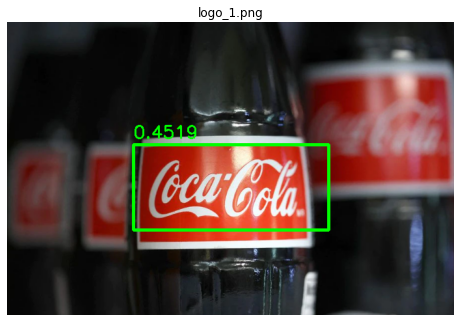

In [49]:
match_template_plot(
    images[0],
    template,
    min_scale=0.5,
    max_scale=2,
    steps=10,
    title=filenames[0],
)

Score: 0.3226


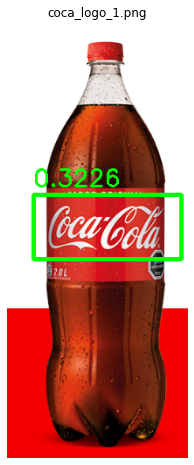

In [50]:
match_template_plot(
    images[1],
    template,
    min_scale=0.4,
    max_scale=0.6,
    steps=10,
    title=filenames[1],
)

Score: 0.5453


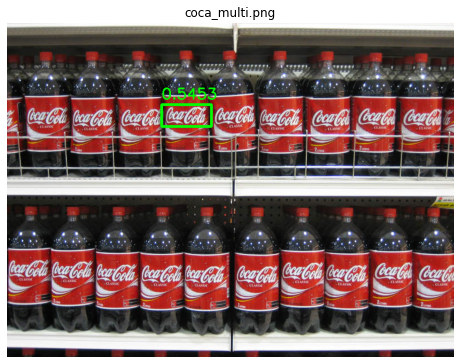

In [51]:
match_template_plot(
    images[2],
    template,
    min_scale=0.2,
    max_scale=0.4,
    steps=10,
    title=filenames[2],
)

In [52]:
images[3].shape

(363, 233, 3)

In [53]:
test = images[3].copy()
test = test[20:, 20:-30, :]

Score: 395861088.0000


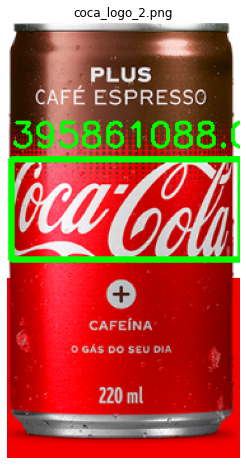

In [54]:
match_template_plot(
    test,
    template,
    min_scale=0.1,
    max_scale=1,
    steps=50,
    title=filenames[3],
    method=cv.TM_SQDIFF,
)

Score: 0.6864


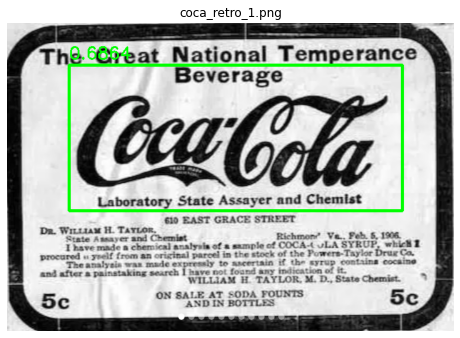

In [55]:
match_template_plot(
    images[4],
    template,
    min_scale=1,
    max_scale=2,
    steps=10,
    title=filenames[4],
)

Score: 0.5662


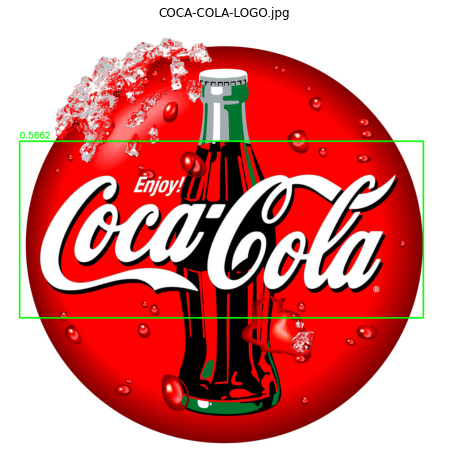

In [56]:
match_template_plot(
    images[5],
    template,
    min_scale=1,
    max_scale=5,
    steps=10,
    title=filenames[5],
)

Score: 0.6295


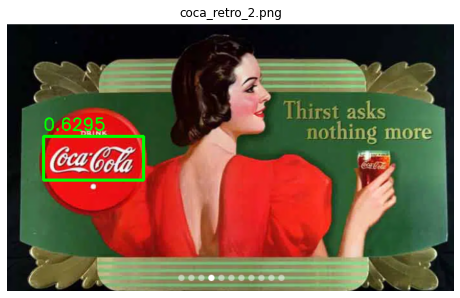

In [57]:
match_template_plot(
    images[6],
    template,
    min_scale=0.1,
    max_scale=1,
    steps=10,
    title=filenames[6],
)

Scores: [0.54940677, 0.5358846, 0.5287621, 0.5091289, 0.51091576, 0.5816743, 0.50735134, 0.5054295, 0.55600226, 0.5130698, 0.5338764, 0.5716462, 0.5786711, 0.54763687, 0.55983824, 0.5287856, 0.5018116, 0.5402104, 0.56255853, 0.5083368, 0.56997544, 0.5331121, 0.503415, 0.53949463, 0.5488225, 0.5149256, 0.546462, 0.5663855, 0.55693215, 0.5119241, 0.5510876, 0.55074286, 0.57067406, 0.5507376, 0.5460277, 0.5300324, 0.50576234, 0.5754317, 0.51381373, 0.52320915, 0.5558712, 0.54313105, 0.51243246, 0.5480101, 0.55393445, 0.55596787, 0.5346632]


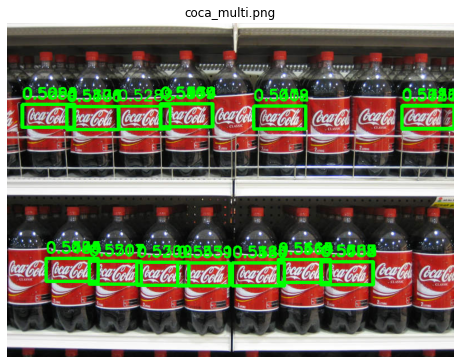

In [58]:
match_template_plot(
    images[2],
    template,
    min_scale=0.1,
    max_scale=0.5,
    steps=10,
    threshold=0.5,
    title=filenames[2],
)